In [1]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

In [2]:
image_folder = '../data/scene_0/sample_0/'
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

In [3]:

def append_images(images, direction='horizontal',
                  bg_color=(255,255,255), aligment='center'):
    """
    Appends images in horizontal/vertical direction.

    Args:
        images: List of PIL images
        direction: direction of concatenation, 'horizontal' or 'vertical'
        bg_color: Background color (default: white)
        aligment: alignment mode if images need padding;
           'left', 'right', 'top', 'bottom', or 'center'

    Returns:
        Concatenated image as a new PIL image object.
    """
    widths, heights = zip(*(i.size for i in images))
    if direction=='horizontal':
        new_width = sum(widths)
        new_height = max(heights)
    else:
        new_width = max(widths)
        new_height = sum(heights)
    
    new_im = Image.new('RGB', (new_width, new_height), color=bg_color)
    offset = 0
    for im in images:
        if direction=='horizontal':
            y = 0
            if aligment == 'center':
                y = int((new_height - im.size[1])/2)
            elif aligment == 'bottom':
                y = new_height - im.size[1]
            new_im.paste(im, (offset, y))
            offset += im.size[0]
            
        else:
            x = 0
            if aligment == 'center':
                x = int((new_width - im.size[0])/2)
            elif aligment == 'right':
                x = new_width - im.size[0]
            new_im.paste(im, (x, offset))
            offset += im.size[1]
    return new_im

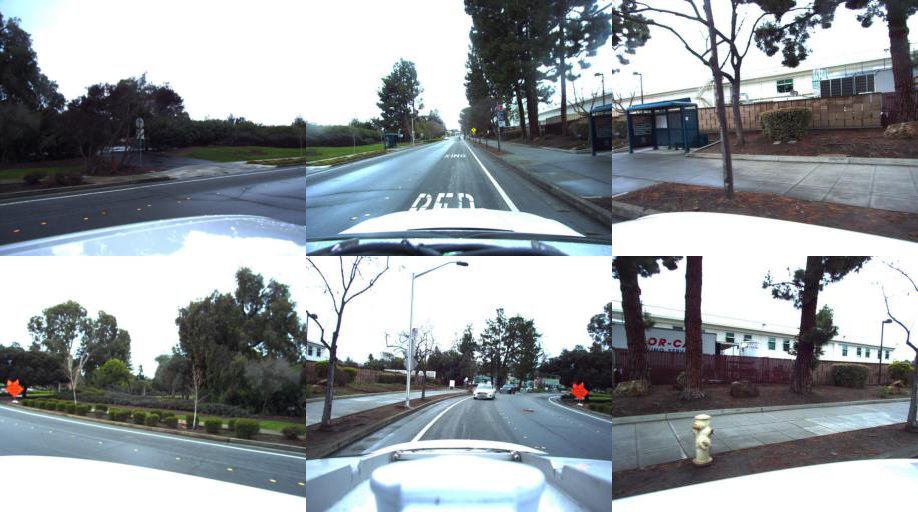

In [6]:
front = map(Image.open, [image_folder+image_names[0], image_folder+image_names[1], image_folder+image_names[2]])

front = [Image.open(image_folder+image_names[0]), Image.open(image_folder+image_names[1]), Image.open(image_folder+image_names[2])]
back = [Image.open(image_folder+image_names[3]), Image.open(image_folder+image_names[4]), Image.open(image_folder+image_names[5])]
combo_1 = append_images(front, direction='horizontal')
combo_2 = append_images(back, direction='horizontal')

out = append_images([combo_1, combo_2], direction='vertical')

out.save(image_folder+'combined.jpeg')
out

In [2]:
import torch

x = torch.randn(3)
y = torch.randn(3)
out = torch.stack([x,y])

print(out)
print(out.shape)
print(out.transpose(0,1))
print(out.transpose(0,1).shape)

tensor([[ 0.3478, -0.3130, -0.1257],
        [ 0.7388,  0.0667, -0.2455]])
torch.Size([2, 3])
tensor([[ 0.3478,  0.7388],
        [-0.3130,  0.0667],
        [-0.1257, -0.2455]])
torch.Size([3, 2])


In [3]:
x.shape

torch.Size([3])

In [2]:
x+y

tensor([ 0.8932, -0.1181, -0.5615])

In [5]:
t = torch.cat([x,y])
t

tensor([ 0.1181,  0.1092, -0.2916,  0.7751, -0.2273, -0.2699])

In [4]:
t = torch.stack([x,x,x])
t

tensor([[ 0.3478, -0.3130, -0.1257],
        [ 0.3478, -0.3130, -0.1257],
        [ 0.3478, -0.3130, -0.1257]])

In [5]:
t.shape

torch.Size([3, 3])

In [8]:
t.unsqueeze(0).shape

torch.Size([1, 3, 3])

In [18]:
out = [(i.item(), j.item()) for i,j in zip(x,y)]
print(out)


print(torch.FloatTensor(out))



[(0.11806106567382812, 0.7750973701477051), (0.10924956947565079, -0.2273353934288025), (-0.29160046577453613, -0.26985952258110046)]
tensor([[ 0.1181,  0.7751],
        [ 0.1092, -0.2273],
        [-0.2916, -0.2699]])


In [19]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
#from my_data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [23]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'



# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)



transform = torchvision.transforms.ToTensor()


# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [24]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


In [27]:
sample[0][0].shape

torch.Size([3, 256, 306])

In [71]:
frist = torch.cat( (sample[0][0], sample[0][1], sample[0][2]), 2)
second = torch.cat( (sample[0][3], sample[0][4], sample[0][5]), 2)

In [46]:
frist.shape

torch.Size([3, 256, 918])

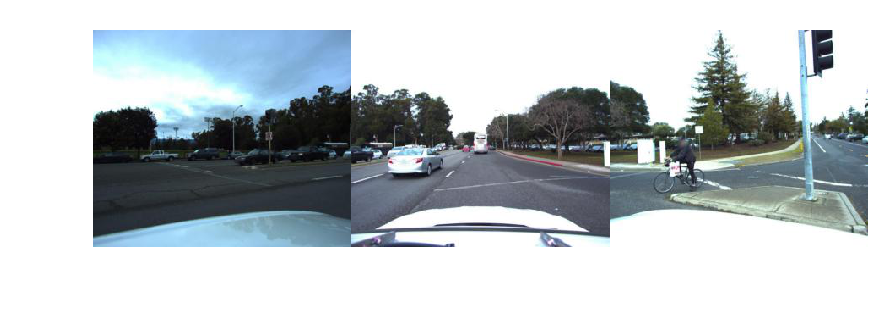

In [47]:
plt.imshow(frist.numpy().transpose(1, 2, 0))
plt.axis('off');

In [72]:
out = torch.cat((frist, second),1)
out.shape

torch.Size([3, 512, 918])

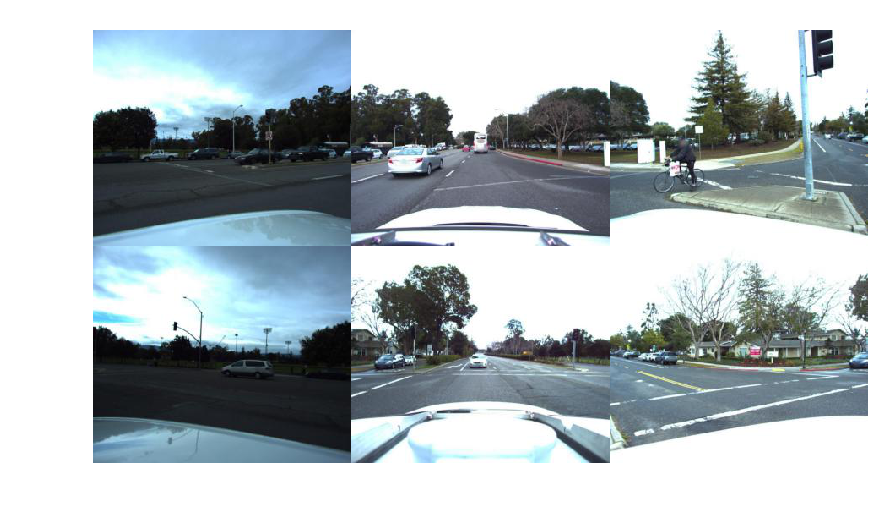

In [73]:
plt.imshow(out.numpy().transpose(1, 2, 0))
plt.axis('off');

In [74]:
new = out.transpose(2,1)

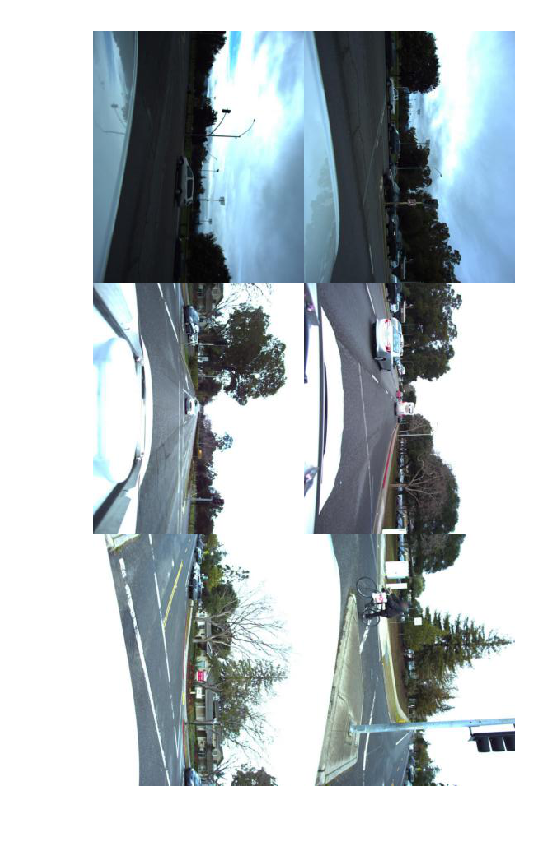

In [75]:
plt.imshow(new.flip(2).numpy().transpose(1, 2, 0))
plt.axis('off');

In [68]:
target[0]['bounding_box'].shape

torch.Size([18, 2, 4])

In [139]:
target[0]['category']

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [155]:
out = []
for i, corners in enumerate(target[0]['bounding_box']):
    curr_category = target[0]['category'][i]
    
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
    
    curr = np.append(point_squence[0].numpy(), curr_category)
    print( curr )
    
    out.append(point_squence[0])
    
out = torch.stack(out)
print(out.shape)

#print(target[0]['category'].unsqueeze(0).shape)

#target[0]['category'].reshape(1,-1).transpose(0,1).shape

[25.48760805 15.79220225  2.        ]
[15.6403218  26.02502869  2.        ]
[27.32585895 12.40606801  2.        ]
[14.27622659  4.72876523  2.        ]
[ -2.66287748 -31.40738511   2.        ]
[ 9.37542784 11.94883489  2.        ]
[ 9.54933607 25.48555203  2.        ]
[ -1.59263644 -37.1786981    2.        ]
[-2.13691774 25.4051662   2.        ]
[ 5.31701354 -3.69753802  1.        ]
[-19.4571149    0.52413553   2.        ]
[-20.44948223 -10.2505821    2.        ]
[-8.26150748 15.29487965  2.        ]
[22.33923901 19.14514995  2.        ]
[ 3.34439838 25.77945948  2.        ]
[16.16366826 11.98928846  2.        ]
[-26.71515972 -10.50796917   2.        ]
[29.38927289 26.32470729  2.        ]
torch.Size([18, 2])


In [127]:
target[0]['category'].reshape(1,-1).unsqueeze(2).transpose(0,1).shape

torch.Size([18, 1, 1])

In [ ]:
test = torch.cat( (out,, 0) )

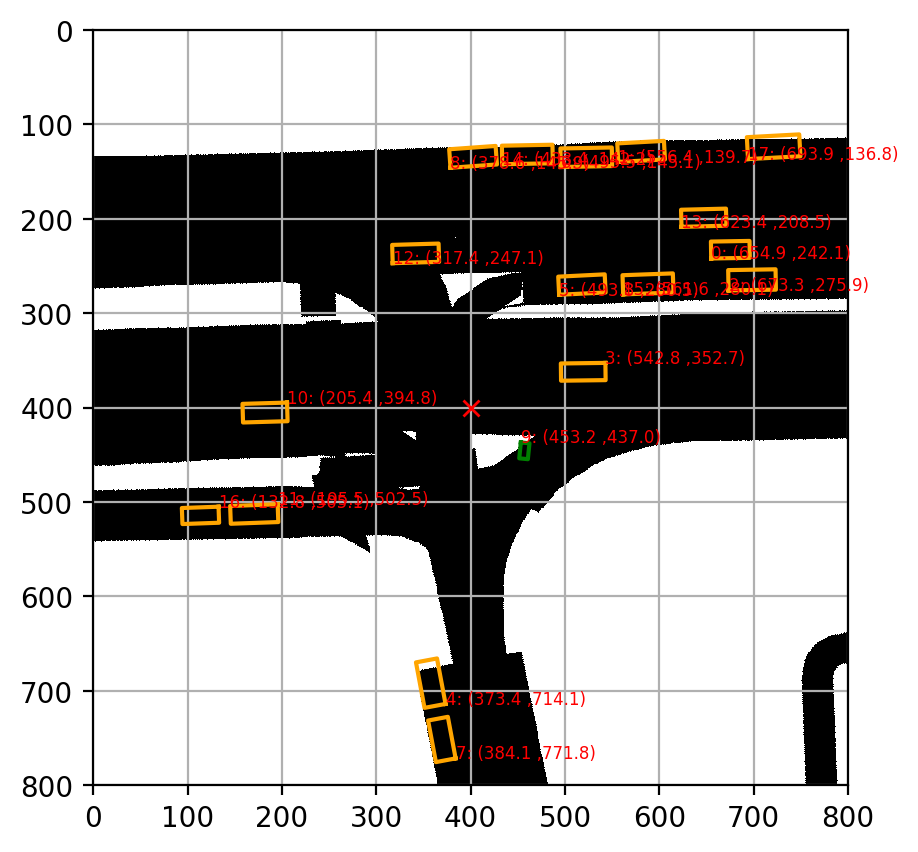

In [157]:
# The center of image is 400 * 400

def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    #ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)
    #print(point_squence.transpose(0,1)[0])
    #print(point_squence.transpose(0,1)[1])
    ax.plot(point_squence.transpose(0,1).numpy()[0] * 10 + 400, -point_squence.transpose(0,1).numpy()[1] * 10 + 400, color=color)
    
   
    
def draw_point(ax, corners, cnt, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    x_ = point_squence.transpose(0,1).numpy()[0][0] * 10 + 400
    y_ = -point_squence.transpose(0,1).numpy()[1][0] * 10 + 400

    text = str(cnt)+': ('+str(round(x_,1))+' ,'+str(round(y_,1))+')'
    ax.annotate(text, xy=(x_,y_), color=color, fontsize=6)
    

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

cnt = 0
for i, bb in enumerate(target[0]['bounding_box']):
    #print(cnt)
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])
    draw_point(ax, bb, cnt, color='r')
    cnt += 1
    
    
ax.grid()